# Colon Cancer Detection and Cell Type Classification

In [2]:
#Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

print('Setup Complete')

Setup Complete


In [3]:
import zipfile
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [5]:
main_data = pd.read_csv('data_labels_mainData.csv')
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [6]:
extra_data = pd.read_csv('data_labels_extraData.csv')
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [7]:
combined_data = pd.concat([main_data,extra_data],axis = 0)

In [8]:
combined_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0


In [9]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 0 to 10383
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   InstanceID    20280 non-null  int64  
 1   patientID     20280 non-null  int64  
 2   ImageName     20280 non-null  object 
 3   cellTypeName  9896 non-null   object 
 4   cellType      9896 non-null   float64
 5   isCancerous   20280 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


In [10]:
print('There are {} patients in our entire data'.format(len(combined_data['patientID'].unique())))

There are 98 patients in our entire data


## Exploratory Data Analysis

### Cell Type Distribution


---



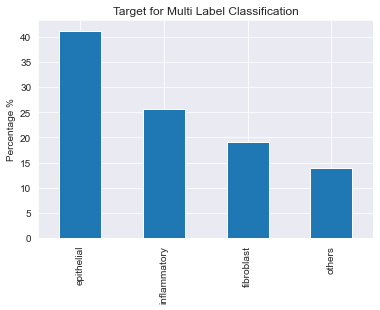

In [11]:
(combined_data['cellTypeName'].value_counts(normalize = True)*100).plot.bar()
plt.ylabel('Percentage %')
plt.title('Target for Multi Label Classification');

### Cancer Cell Distribution

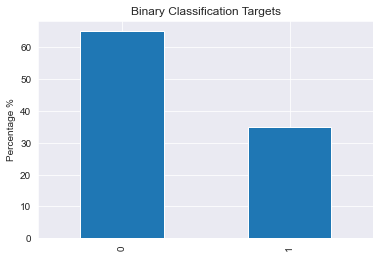

In [12]:
(combined_data['isCancerous'].value_counts(normalize = True)*100).plot.bar()
plt.ylabel('Percentage %')
plt.title('Binary Classification Targets');

Looking at the target labels, it is evident that both class labels for cancer/non-cancer and cellTypes are imbalanced.Therefore,for our learning tasks we used macro-average f1-score as a metric to evaluate the performance of class labels. This metrics is calculated giving importance for each class labels and for further evaluation, we select confusion matrix, precision and recall.

In [14]:
from PIL import Image

In [13]:
base_dir = 'patch_images/'

In [15]:
combined_data['Image_path'] = combined_data['ImageName'].apply(lambda x : base_dir + x)
combined_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image_path
0,22405,1,22405.png,fibroblast,0.0,0,patch_images/22405.png
1,22406,1,22406.png,fibroblast,0.0,0,patch_images/22406.png
2,22407,1,22407.png,fibroblast,0.0,0,patch_images/22407.png
3,22408,1,22408.png,fibroblast,0.0,0,patch_images/22408.png
4,22409,1,22409.png,fibroblast,0.0,0,patch_images/22409.png


In [16]:
fibroblast = combined_data.loc[combined_data['cellType']==0].sample(4)
inflammatory = combined_data.loc[combined_data['cellType']==1].sample(4)
epithelial = combined_data.loc[combined_data['cellType']==2].sample(4)
others = combined_data.loc[combined_data['cellType']==3].sample(4)

### Images for 4 types of CellTypes

In [17]:
def plot_images(df,title):
  fig = plt.figure(figsize = (15,8))
  for i, img in enumerate(df):
    fig.add_subplot(2,4,i+1)
    plt.imshow(Image.open(img))
    plt.axis('off')
    fig.suptitle(title, fontsize = 20) 
  plt.tight_layout(rect = [0, 0.03, 1, 0.95])
  return plt.show()

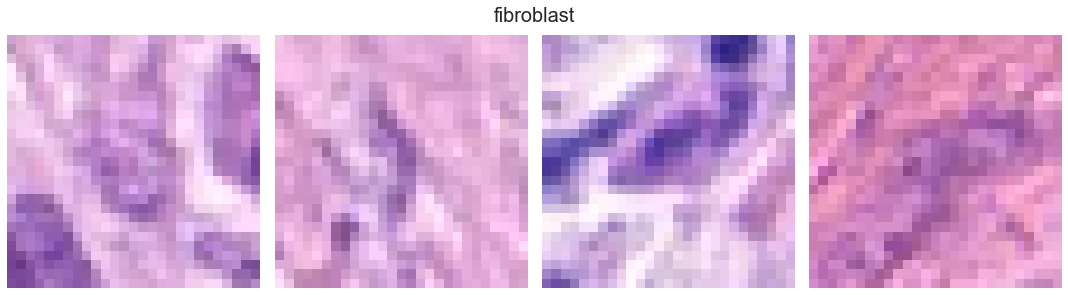

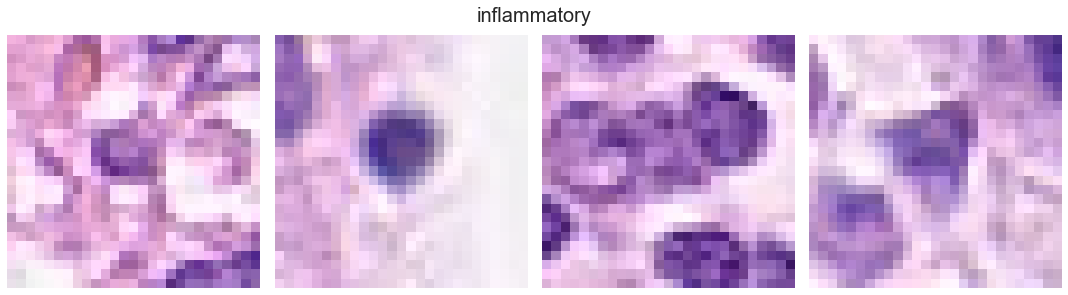

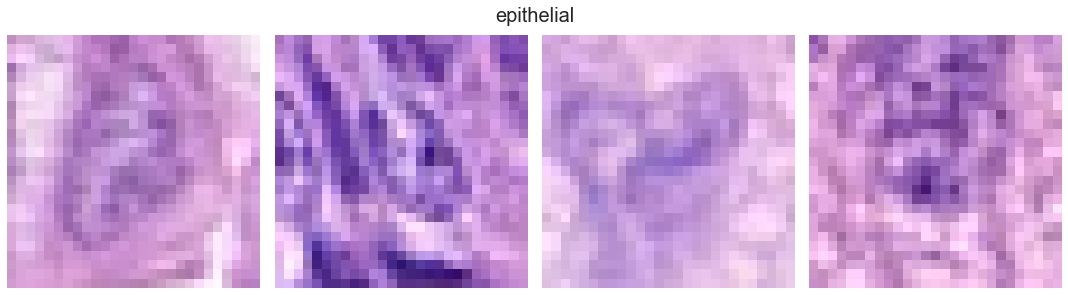

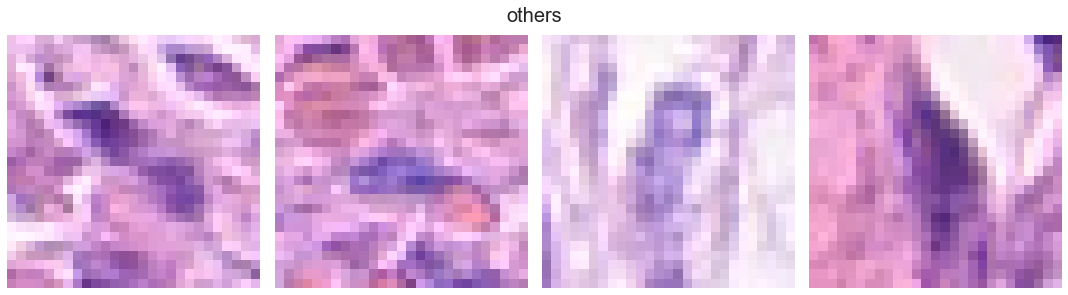

In [18]:
img_labels = [fibroblast,inflammatory,epithelial,others]
for labels in img_labels:
  label = str(labels['cellTypeName'].iloc[0])
  plot_images(labels['Image_path'],label)

### Images for Cancer and Non-Cancer Cells

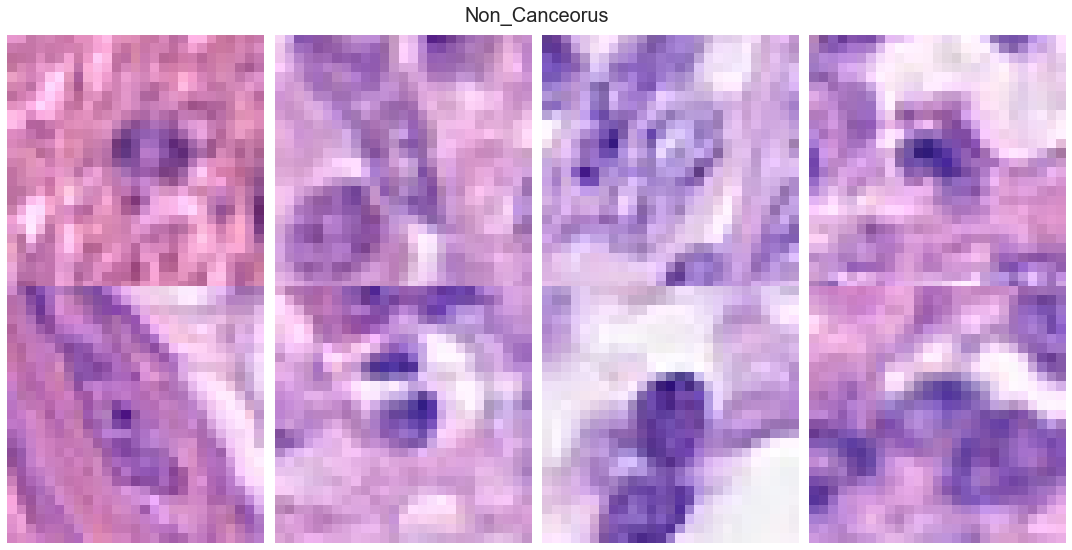

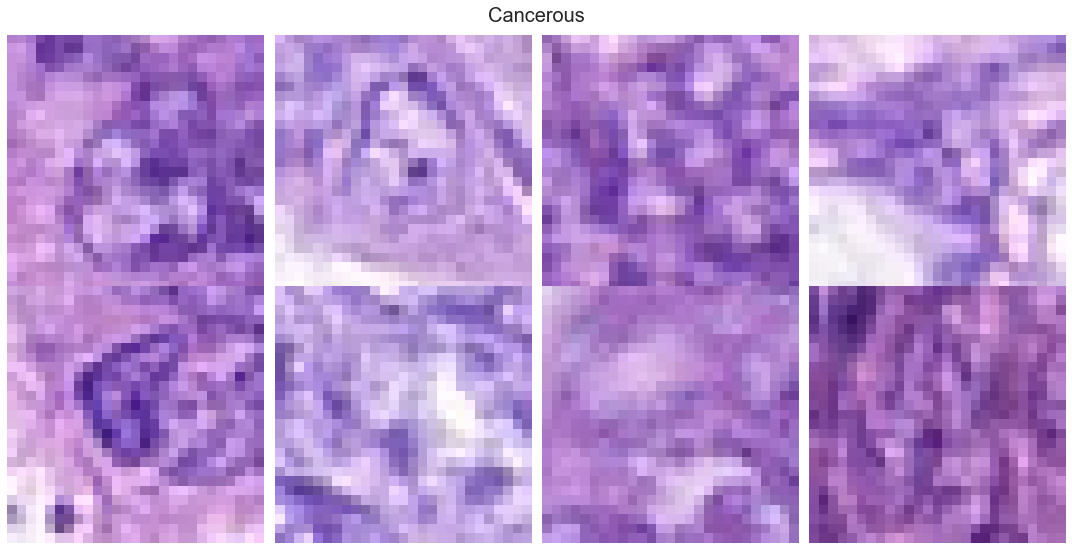

In [19]:
cancer = combined_data.loc[combined_data['isCancerous']==1].sample(8)
not_cancer = combined_data.loc[combined_data['isCancerous']==0].sample(8)

isCancerous = [not_cancer,cancer]
can_label  = ['Non_Canceorus','Cancerous']
for i, labels in enumerate(isCancerous):
  plot_images(labels['Image_path'],can_label[i])

Looking at the images, it is every difficult to manual extract features as they look very identical. Hence, we intend to use deep neural networks and convolutional filters to automatically extract features and use it for predictions. As our images corresponds to patients with their ID, we use this column to divide our dataset into three splits: train, validation and test split. We also inspect the splits to see if there are any potential data leakage.

In [ ]:
#Split train, validation and test based on patient ID. 
from sklearn.model_selection import GroupShuffleSplit

train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(combined_data, groups=combined_data['patientID']))

train_data = combined_data.iloc[train_inds]
test_data = combined_data.iloc[test_inds]

train_ind, val_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(train_data, groups=train_data['patientID']))

val_data  = train_data.iloc[val_inds]

train_data = train_data.iloc[train_ind]


print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 13176, Val Data: 3148, Test Data: 3956


In [ ]:
#Check whether there are any data leakage while splitting
print('Train and Test Set Intersection', (pd.Index(train_data).intersection(pd.Index(test_data))).values)
print('Train and Validation Set Intersection ', (pd.Index(train_data).intersection(pd.Index(val_data))).values)
print('Validation and Test Set Intersection ', (pd.Index(val_data).intersection(pd.Index(test_data))).values)

Train and Test Set Intersection []
Train and Validation Set Intersection  []
Validation and Test Set Intersection  []


In [ ]:
print('There are {} patients in Training Set'.format(len(train_data['patientID'].unique())))
print('There are {} patients in Validation Set'.format(len(val_data['patientID'].unique())))
print('There are {} patients in Test Set'.format(len(test_data['patientID'].unique())))

There are 62 patients in Training Set
There are 16 patients in Validation Set
There are 20 patients in Test Set


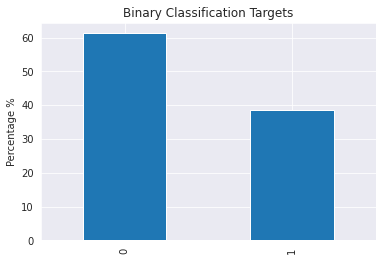

In [ ]:
(train_data['isCancerous'].value_counts(normalize = True)*100).plot.bar()
plt.ylabel('Percentage %')
plt.title('Binary Classification Targets');

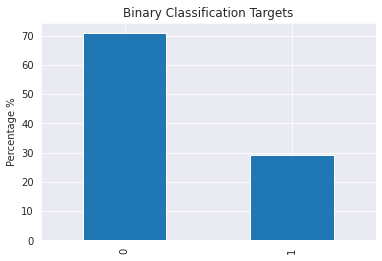

In [ ]:
(val_data['isCancerous'].value_counts(normalize = True)*100).plot.bar()
plt.ylabel('Percentage %')
plt.title('Binary Classification Targets');

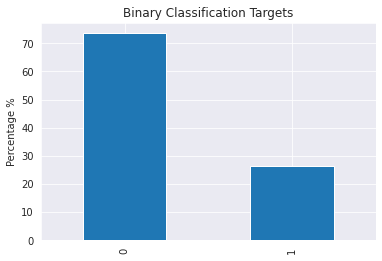

In [ ]:
(test_data['isCancerous'].value_counts(normalize = True)*100).plot.bar()
plt.ylabel('Percentage %')
plt.title('Binary Classification Targets');